# Stochastic Neighbor Embedding(SNE)

## 符号定义
|符号|含义|
|:--:|:--:|
|$\pmb{x}$|数据点|
|X|数据点集合|
|$\pmb{y}$|降维后数据点|
|$p_{ij}$|原空间中数据点$\pmb{x_j}$是数据点$\pmb{x_i}$的邻近点的概率|
|$q_{ij}$|低维空间中数据点$\pmb{y_j}$是数据点$\pmb{y_i}$的邻近点的概率|
|$\mathcal{L}$|损失函数|
|$d$|原空间维度|
|$m$|降维后维度|
|$W$|权重矩阵|
|$D$|度矩阵|

## 概念

SNE尝试从概率的角度阐述数据点的相似性，即对于特定的数据点$\pmb{x_i}$，该数据点以概率$p_{ij}$选择数据点$\pmb{x_j}$作为它的近邻点，对于所有的数据点有
$$
\begin{equation}
    \sum_{i\neq j}p_{ij} = 1
\end{equation}
$$

上述概率$p_{ij}$越大说明数据点$\pmb{x_j}$越有可能是数据点$\pmb{x_i}$的近邻点，数据点$\pmb{x_j}$和$\pmb{x_i}$相似性越高。

通过上述方式定义了相似性后，SNE在低维空间$\mathcal{R}^m$中寻找一个集合$Y$，使得$Y$中的点与原空间中的数据点一一对应，并且有近似的相似性度量结果。

SNE主要有如下步骤：

1. 在原空间中计算任意两点间的概率$p_{ij}$
2. 在低维空间中随机生成一个集合，使得该集合中的点与原空间中的数据点一一对应，并计算任意两点间的概率$q_{ij}$
3. 使用损失函数计算当前两个概率分布的相似性
4. 优化集合$Y$，使得损失函数尽可能小

## 推导

* **原空间的相似度评价**

SNE中以高斯核函数为基础计算概率$p_{ij}$。**值得说明的是，这里的概率应当为条件概率，并不是联合概率，为了和原论文中的符号保持一致没有使用$p_{j|i}$**

$$
\begin{equation}
    p_{ij} = \frac{\exp{(-||\pmb{x_i}-\pmb{x_j}||^2/2\sigma_i^2)}}{\sum_{z\neq j}\exp{(-||\pmb{x_i}-\pmb{x_z}||^2/2\sigma_i^2)}}
\end{equation}
$$

上述计算结果和DiffusionMaps中的计算方式一致，也与拉普拉斯矩阵的随机游走归一化类似。不同的是，DiffusionMaps将上式解释为转移概率，表示从点$\pmb{x_i}$转移到点$\pmb{x_j}$的概率，并在此基础上引入图上的随机游走；而SNE则将上式视为条件概率，表示点$\pmb{x_i}$选择点$\pmb{x_j}$作为其近邻点的概率。不同的理解方式导致了截然不同的后续流程，还是很有意思。

为了简化表达方式，在这里引入权重矩阵和度矩阵

对于权重矩阵

$$
\begin{equation}
    \begin{split}
    W 
    &= [w_{ij}] \\
    &= \exp{(-||\pmb{x_i}-\pmb{x_j}||^2/2\sigma_i^2)}
    \end{split}
\end{equation}
$$

对于度矩阵
$$
\begin{equation}
    D = [d_{ij}] = 
    \left\{
    \begin{array}{cc}
        0, &i \neq j \\
        \sum_{z\in X}w_{iz}, &i=j
    \end{array}
    \right.
\end{equation}
$$

由此可得原空间中的概率更为紧凑的形式
$$
\begin{equation}
    P = D^{-1}W
\end{equation}
$$

上述分析还存在一个问题：$\sigma_i$如何确定？

Hinton在论文中指出[1]，$\sigma_i$可以依照经验直接指定，也可以用二分法搜索$\sigma_i$使得上述分布的困惑度(perplexity)为一个固定的指定值，即

$$
\begin{equation}
    perplexity(p_i) = 2^{H(p_i)} = c
\end{equation}
$$
其中$c$为一个常数，$H(p_i)$为信息熵

$$
\begin{equation}
    H(p_i) = -\sum_jp_{ij}\log_2(p_{ij})
\end{equation}
$$

* **低维表示的相似度评价**

在低维空间中，SNE使用类似的方式进行相似度评价。不同点是，在低维空间中使用固定的方差，其结果如下式

$$
\begin{equation}
    q_{ij} = \frac{\exp{(-||\pmb{y_i}-\pmb{y_j}||^2)}}{\sum_{z\neq j}\exp{(-||\pmb{y_i}-\pmb{y_z}||^2)}}
\end{equation}
$$

同样的，可以写为更为紧凑的矩阵的形式

$$
\begin{equation}
    Q = D_{low}^{-1}W_{low}
\end{equation}
$$

其中$W_{low}$表示低维空间的权重矩阵，$D_{low}$表示低维空间的度矩阵，计算方式同式-3和式-4.

* **损失函数**

不同于DiffusionMaps找到了高维空间中扩散距离和低维空间欧式距离之间的联系，SNE直接使用KL散度度量两个分布的差异，即

$$
\begin{equation}
    \mathcal{L} = \sum_{i}\sum_{j}p_{ij}\log{\frac{p_{ij}}{q_{ij}}} = \sum_{i}KL(P_i||Q_i)
\end{equation}
$$

值得注意的是KL散度不对称，这种不对称会造成度量上的缺陷。

对于KL损失，当$p_{ij}$较大时，其对总损失的影响大，为了减小损失，$q_{ij}$会尽量和$p_{ij}$相同；但是当$p_{ij}$较小时，其对总损失的影响小，此时$q_{ij}$和$p_{ij}$之间的差异影响不大。即对于$p_{ij}$较大的位置，其惩罚大；对于$q_{ij}$较小的位置，其惩罚小。

上述缺陷反映到降维上则会导致如下问题：原本相近的两个点（$p_{ij}$较大），降维后变化大($q_{ij}$和$p_{ij}$差别大)，会有一个较大的惩罚；原本相离的两个点（$p_{ij}$较小），降维后变化大($q_{ij}$和$p_{ij}$差别大)，会有一个较小的惩罚。

KL散度的这一特点会导致对原空间中就相离的点监督不足，降维后容易聚集到一起。即KL散度相较于全局，更为关注局部的结构。

* **监督学习**

有了损失函数后监督学习即可，这里采用梯度下降法

$$
\begin{equation}
    \frac{\partial\mathcal{L}}{\partial{\pmb{y_i}}} = 2\sum_{j}(p_{ij}-q_{ij}+p_{ji}-q_{ji})(\pmb{y_i}-\pmb{y_j})
\end{equation}
$$


## 算法流程

1. 定义数据集$X$，降维后维度m
2. 确定参数$\sigma$
3. 在低维空间中随机生成降维结果
4. 计算降维前后的权重矩阵、度矩阵以及概率矩阵
5. 利用梯度下降法优化降维结果
6. 重复4、5直至达到迭代结束条件

## 参考资料

[1] G.E. Hinton, S. Roweis. Stochastic neighbor embedding[J]. Advances in neural information processing systems, 2002, 15.

[2] https://ww2.mathworks.cn/help/stats/t-sne.html#bviy7hm-1

[3] http://bindog.github.io/blog/2016/06/04/from-sne-to-tsne-to-largevis/#0x02-%E4%BB%8Esne%E8%AF%B4%E8%B5%B7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import torch
from torchvision import transforms, datasets

from sklearn.manifold import _utils
from scipy.stats import entropy
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
class MySNE(object):

    def __init__(self, n_components, perplexity, random_state=1024):

        self.n_components = n_components
        self.perplexity = perplexity
        self.random_state = random_state

        self.input_data = None

        self.condition_p = None
        self.condition_q = None
        
    def fit_transform(self, input_data, lr=1e-3, max_iter=1000, min_loss=1e-3):

        self.input_data = np.array(input_data)
        n_samples, sample_dims = self.input_data.shape

        # compute condition p
        self._compute_condition_p(self.input_data)

        # create reduction result
        np.random.seed(self.random_state)
        reduction_mat = np.random.randn(n_samples, self.n_components)

        # iter
        iter_count = 0
        _loss = min_loss + 1
        iter_done = False

        # min_lr = lr * 1e-4
        # lr_list = np.linspace(lr, min_lr, max_iter)
        
        while not iter_done:
            
            # compute condition q
            self._compute_condition_q(reduction_mat)
            # update reduction result
            condition_p_double = self.condition_p + self.condition_p.T
            condition_q_double = self.condition_q + self.condition_q.T
            condition_double = condition_p_double - condition_q_double

            if iter_count % 100 == 0:
                _loss = np.sum(entropy(self.condition_p, self.condition_q))
                print("iter:{}\tloss:{:.4f}".format(iter_count, _loss))

            # lr = lr_list[iter_count]
            for i in range(n_samples):
                temp_mat_1 = np.tile(reduction_mat[i, :].reshape(1, -1), (n_samples, 1))
                reduction_mat[i, :] -= lr * np.matmul(condition_double[i, :].reshape(1, -1), temp_mat_1 - reduction_mat).reshape(-1)
            
            iter_count += 1
            if _loss < min_loss or iter_count >= max_iter:
                iter_done = True
        
        return reduction_mat
    
    def _compute_condition_p(self, input_data):
        distance_vector = pairwise_distances(input_data, squared=True).astype(np.float32, copy=False)
        self.condition_p = _utils._binary_search_perplexity(distance_vector, self.perplexity, False)
    
    def _compute_condition_q(self, input_data):
        distance_mat = pairwise_distances(input_data, squared=True).astype(np.float32, copy=False)
        weight_mat = np.exp(-distance_mat)
        metric_mat = np.diag(1/np.sum(weight_mat, axis=1))
        self.condition_q = np.matmul(metric_mat, weight_mat)

iter:0	loss:10614.6795
perplexity:25
iter:0	loss:13167.0320
iter:100	loss:6991.9823
iter:200	loss:5871.2161
iter:300	loss:5506.5564
iter:400	loss:5376.8996
perplexity:50
iter:0	loss:11912.9680
iter:100	loss:5894.3973
iter:200	loss:4852.4968
iter:300	loss:4588.4525
iter:400	loss:4462.7583
perplexity:75
iter:0	loss:11154.4430
iter:100	loss:5261.8892
iter:200	loss:4284.3351
iter:300	loss:4031.3409
iter:400	loss:3956.9673
perplexity:100
iter:0	loss:10614.6795
iter:100	loss:4824.7544
iter:200	loss:3890.2016
iter:300	loss:3691.3725
iter:400	loss:3647.2014
perplexity:150
iter:0	loss:9848.0526
iter:100	loss:4248.5288
iter:200	loss:3382.2910
iter:300	loss:3252.7330
iter:400	loss:3216.4059


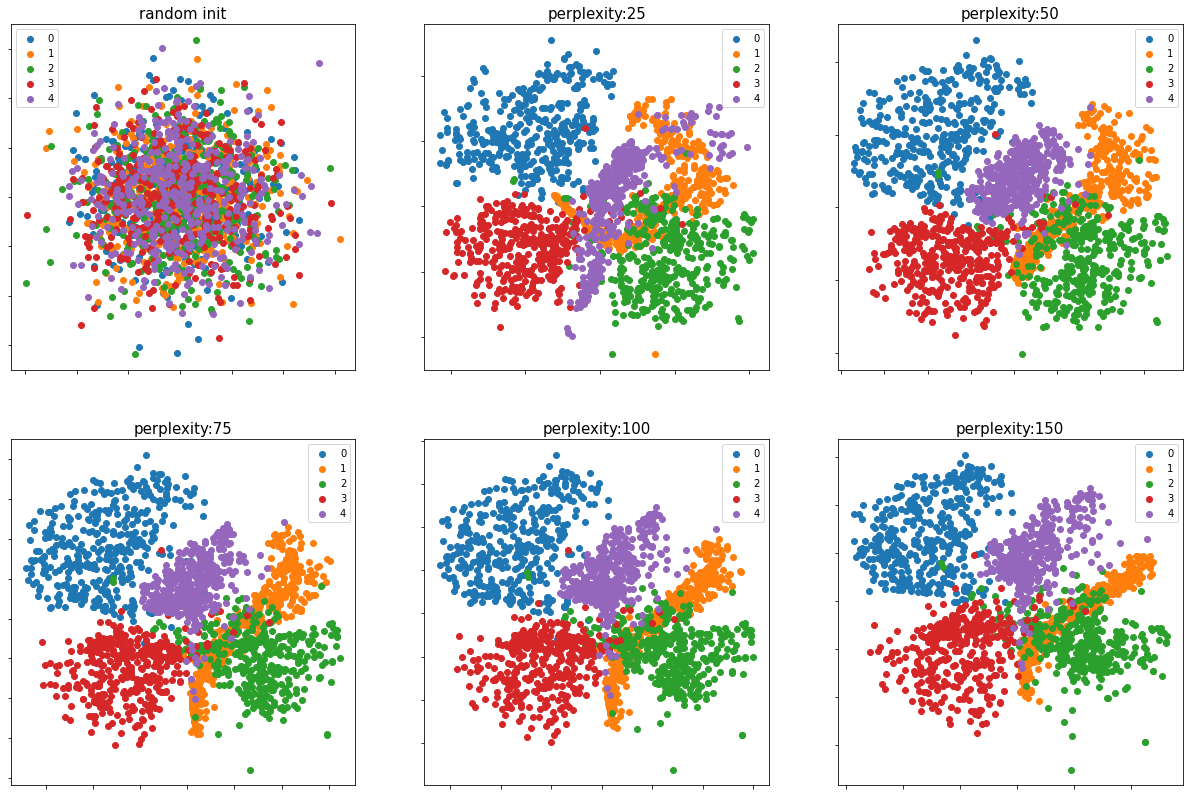

In [10]:
# ------------------------------- data -------------------------------------------
transform_ = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
data_total = datasets.MNIST('../data/mnist', train=True, transform=transform_, download=True)

# using 0~4
data_index = torch.where(data_total.targets < 5)
data_total.targets = data_total.targets[data_index][:2000]
data_total.data = data_total.data[data_index][:2000]

perplexity_list = [25, 50, 75, 100, 150]

# ------------------------------ draw ----------------------------------
fig = plt.figure(figsize=(21, 14))

mySNE = MySNE(2, 100)
mySNE_result = mySNE.fit_transform(data_total.data.numpy().reshape(-1, 28*28), lr=5e-2, max_iter=1)
ax = fig.add_subplot(231)
plt.title("random init", fontsize=15)
for i in np.unique(data_total.targets.numpy()):
    point_index_list = np.argwhere(data_total.targets == i)
    ax.scatter(mySNE_result[point_index_list, 0], mySNE_result[point_index_list, 1], cmap=plt.cm.Spectral, label=i)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")
plt.legend()

for c, perplexity in enumerate(perplexity_list):
    print("perplexity:{}".format(perplexity))
    mySNE = MySNE(2, perplexity)
    mySNE_result = mySNE.fit_transform(data_total.data.numpy().reshape(-1, 28*28), lr=3e-2, max_iter=500)
    ax = fig.add_subplot(2, 3, c+2)
    plt.title("perplexity:{}".format(perplexity), fontsize=15)
    for i in np.unique(data_total.targets.numpy()):
        point_index_list = np.argwhere(data_total.targets == i)
        ax.scatter(mySNE_result[point_index_list, 0], mySNE_result[point_index_list, 1], cmap=plt.cm.Spectral, label=i)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    plt.legend()

plt.show()